# Estimating dissimilarities

This tutorial shows how to estimate Representational Dissimilarity Matricies (RDMs) from data.

In [35]:
# relevant imports
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
%matplotlib inline

We first generate an example dataset we want to calculate RDM(s) from. If you are unfamiliar with the dataset object in rsatoolbox, have a look at `demo_dataset.ipynb`. 

For this tutorial we use simulated data for the 92 image dataset, which come with the toolbox and are here just loaded:

In [36]:
# create a dataset object
measurements = io.matlab.loadmat('92imageData/simTruePatterns.mat')
measurements = measurements['simTruePatterns2']
nCond = measurements.shape[0]
nVox = measurements.shape[1]
# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_%02d' % x for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
data = rsd.Dataset(measurements=measurements,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des)

### Calculating our first RDM
The main function to calculate RDMs from data is `rsatoolbox.rdm.calc_rdm` to which we have abbreviated access as `rsr.calc_rdm` here. The function takes a dataset object as its main input. Additionally, we here pass the descriptor 'conds' to specify that we want to create a RDM of dissimilarities between conditions as specified by 'conds'. If this input is not provided the RDM is calculated assuming that each row is a separate pattern or condition. To avoid confusion, we generally recommend to pass the `descriptor` argument.

In [37]:
# calculate a RDM
RDM_euc = rsr.calc_rdm(data, descriptor='conds')
print(RDM_euc)

rsatoolbox.rdm.RDMs
1 RDM(s) over 92 conditions

dissimilarity_measure = 
squared euclidean

dissimilarities[0] = 
[[0.         1.79168033 1.79025977 ... 2.34585297 2.34306615 2.37794181]
 [1.79168033 0.         1.82424097 ... 2.3153871  2.28580169 2.32155829]
 [1.79025977 1.82424097 0.         ... 2.40876617 2.36854597 2.32501722]
 ...
 [2.34585297 2.3153871  2.40876617 ... 0.         1.76469464 1.72393365]
 [2.34306615 2.28580169 2.36854597 ... 1.76469464 0.         1.78983719]
 [2.37794181 2.32155829 2.32501722 ... 1.72393365 1.78983719 0.        ]]

descriptors: 

rdm_descriptors: 
session = [1]
subj = [1]
index = [0]

pattern_descriptors: 
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 

As you see the RDMs object can be printed for easy inspection.
The calculated dissimilarities are saved as a vector of strung-out upper-triangular elements of the RDM matrix. Note also that the RDM object inherits the descriptors from the dataset object.

By default `calc_rdm` computes squared euclidean distances between mean patterns. If we want to compute a different type of RDM, we can do so by passing the `method` parameter. See https://rsa3.readthedocs.io/en/latest/distances.html for a discussion of different methods for calculating RDMs.
For example we can calculate correlation distances like this:

In [38]:
RDM_corr = rsr.calc_rdm(data, method='correlation', descriptor='conds')

For the Euclidean and Mahalanobis distances there are squared and non-squared variants, which are both used sometimes. By default rsatoolbox calculates the squared dissimilarities. To compute non-square distances, use the sqrt_transform function in rsatoolbox.rdm. To compute a non-squared euclidean distance RDM this would look like this:

In [39]:
RDM_euc = rsr.calc_rdm(data, method='euclidean', descriptor='conds')
RDM_euc_nonsquared = rsatoolbox.rdm.sqrt_transform(RDM_euc)

### accessing RDM contents
To access the dissimilarities saved in the rdms object use the `get_matrices` and `get_vectors` functions. These functions always have a starting dimension for multiple rdms as the rdms object can store multiple rdms.

In [40]:
dist_vectors = RDM_euc.get_vectors() # here a vector
dist_matrix = RDM_euc.get_matrices()
print(dist_matrix)
print(dist_matrix.shape)
print(dist_vectors.shape)

[[[0.         1.79168033 1.79025977 ... 2.34585297 2.34306615 2.37794181]
  [1.79168033 0.         1.82424097 ... 2.3153871  2.28580169 2.32155829]
  [1.79025977 1.82424097 0.         ... 2.40876617 2.36854597 2.32501722]
  ...
  [2.34585297 2.3153871  2.40876617 ... 0.         1.76469464 1.72393365]
  [2.34306615 2.28580169 2.36854597 ... 1.76469464 0.         1.78983719]
  [2.37794181 2.32155829 2.32501722 ... 1.72393365 1.78983719 0.        ]]]
(1, 92, 92)
(1, 4186)


Also, for a quick look we can plot the RDM using `rsatoolbox.vis.show_rdm`:

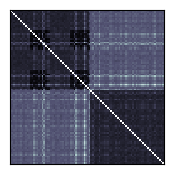

In [41]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(RDM_euc)

If you already calculated a RDM in some different way you can turn your RDM into a RDM object for use in rsatoolbox by using the constructor `rsatoolbox.rdm.RDMs`. If you want to use descriptors for the conditions or rdms you put into the object you need to specify them as dictionaries of lists as for the dataset object.

The following thus creates a naked RDMs object, which only contains the dissimilarities and no specific descriptors.

In [42]:
# create an RDM object with given entries:
dissimilarities = RDM_euc.get_vectors()
RDM_euc_manual = rsr.RDMs(dissimilarities)

## create RDM object for several RDMs
When we have multiple datasets we can compute the RDMs for each by simply passing the whole list to the function. This is convenient when we want to compute RDMs for multiple subjects, conditions, brain areas, etc.

To illustrate this let's start by creating a list of 5 datasets with noisy copies of the measurements we already have, labeling them as coming from different subjects in the descriptor `'subj'`:

In [43]:
data_list = []
for i in range(5):
    m_noisy = measurements + np.random.randn(*measurements.shape)
    des = {'session': 1, 'subj': i}
    data_list.append(rsd.Dataset(measurements=m_noisy,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des))

As promised we can now calculate the RDMs for all subjects in one go:

In [44]:
rdms = rsr.calc_rdm(data_list)

Note, that `rdms` is a single object, which contains all RDMs. The functions for accessing the vector representation and the matrix representation are still available. Additionally, the number of RDMs and the descriptiors we gave to the dataset objects are kept:

In [45]:
print('The number of RDMs is:')
print(rdms.n_rdm)
print()
print('The descriptors for the RDMs are:')
print(rdms.rdm_descriptors)
print()
print('The patterns or conditions are still described at least by their label:')
print(rdms.pattern_descriptors['pattern'])

The number of RDMs is:
5

The descriptors for the RDMs are:
{'session': [1, 1, 1, 1, 1], 'subj': [0, 1, 2, 3, 4], 'index': [0, 1, 2, 3, 4]}

The patterns or conditions are still described at least by their label:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]


### To access the parts of the rdms object a few functions are available:
To access only a subset of the rdms in the object use the `subset` and `subsample` functions:
The inputs to these functions are a descriptor used for the selection and a list (or other iterable) of selected values.

The difference between the two function lies in how they treat repetitions. If you pass a value twice subsample will repeat the rdm in the returned object, while subset will return every rdm at most once.

In [46]:
# same output:
r1 = rdms.subset('subj', [1, 3, 4])
r2 = rdms.subsample('subj', [1, 3, 4])
# different output
r3 = rdms.subset('subj', [1, 3, 3, 4])
r4 = rdms.subsample('subj', [1, 3, 3, 4])
# r3 has 3 rdms r4 has 4 rdms

Equivalent syntax for selecting a subset of the patterns is implemented as `subset_pattern` and `subsample_pattern`.

For repeated values subsample will fill in dissimilarities between patterns and themselves as `np.nan`.

In [47]:
# same output:
r1 = rdms.subset_pattern('pattern', [1, 3, 4, 5, 6, 72])
r2 = rdms.subsample_pattern('pattern', [1, 3, 4, 5, 6, 72])
# different output
r3 = rdms.subset_pattern('pattern', [1, 3, 3, 4, 5, 6, 72])
r4 = rdms.subsample_pattern('pattern', [1, 3, 3, 4, 5, 6, 72])
# r3 has 6 conditions r4 has 7 conditions

Indexing and iterating over RDMs is also supported, i.e. `rdms[0]` will return the first rdm and `for rdm in rdms:` are legal commands. These commands return copies though!, i.e. `rdms[0]` and `rdm` will be copies of the corresponding rdms and changing them will not affect the original rdms object.

And of course we can still show the rdm in a plot using `rsatoolbox.vis.show_rdm`:

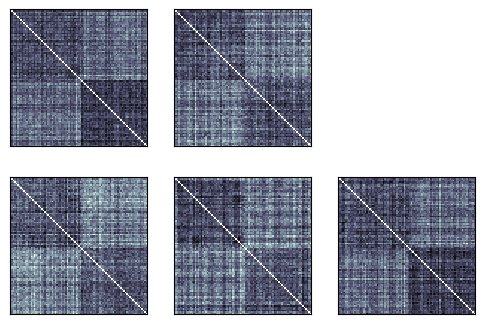

In [48]:
rsatoolbox.vis.show_rdm(rdms)
None

## Crossvalidated dissimilarities
When we have multiple independent measurements of a pattern we can use crossvalidated distances to achieve an unbiased estimate of the dissimilarities between patterns. Essentially, this is meant to counteract the upward bias caused by adding noise to the measurements. You may have noticed this bias by comparing the noisy RDMs we just created and the clean rdm we created at the beginning of this tutorial.

To illustrate how to do this using rsatoolbox, we first create a dataset with multiple (`n_rep`) measurements for each pattern:

In [49]:
n_rep = 3
m_noisy = np.repeat(measurements, n_rep, axis=0)
m_noisy += np.random.randn(*m_noisy.shape)
    
conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
sessions = np.tile(np.arange(n_rep), 92)
conds = np.repeat(conds, n_rep)
obs_des = {'conds': conds, 'sessions': sessions}

des = {'subj': 1}

dataset = rsd.Dataset(
    measurements=m_noisy,
    descriptors=des,
    obs_descriptors=obs_des,
    channel_descriptors=chn_des)

Importantly, we added a sessions descriptor which marks which measurement comes from which session. We can now compute the crossvalidated distances simply using the `'crossnobis'` rdm calculation method. To specify which measurements come from the same session we pass `'sessions'` as the `cv_descriptor`. 

In [50]:
rdm_cv = rsatoolbox.rdm.calc_rdm(dataset, method='crossnobis', descriptor='conds', cv_descriptor='sessions')

/Users/jasper/projects/rsatoolbox/env/lib/python3.10/site-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(


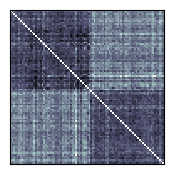

In [51]:
rsatoolbox.vis.show_rdm(rdm_cv)
None

Looking at this rdm, we can see that this indeed removed the overall upward bias, although the rdm is still noisy of course.

If you have multiple datasets for multiple subjects this will still work fine with the crossnobis dissimilarity.

## Taking the noise covariance into account
It is possible to take into account the noise covariance to get a more reliable estimate of the RDM. For computational efficiency reasons all functions which compute these dissimilarities in this toolbox take the precision matrix as input.

To do so, the first step is to estimate the noise precision matrix. There are multiple estimates implemented in rsatoolbox.


### diagonal covariance from measurements = univariate noise normalization
The first one is computing the variances and using the diagonal precision matrix, which is equivalent to normalizing each channel separately.

In [52]:
# the covariance is never used in rsatoolbox
# noise_cov_diag = rsatoolbox.data.noise.cov_from_measurements(dataset, obs_desc='conds', method='diag')
# computing the precision matrix (inverse of CoV) instead:
noise_prec_diag = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='diag')

### shrinkage estimate from measurements = multivariate noise normalization
The second method for estimating the noise covariance are shrinkage estimates which mix a diagonal matrix with the sample covariance to achieve an invertible, more accurate estimate of the covariance.

In rsatoolbox this is implemented in the same function, just changing the method parameter. There are two variants: `'shrinkage_eye'` implements a shrinkage towards a multiple of the diagonal, `'shrinkage_diag'` shrinks towards the data diagonal.

In [53]:
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='shrinkage_eye')

In [ ]:
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='shrinkage_diag')

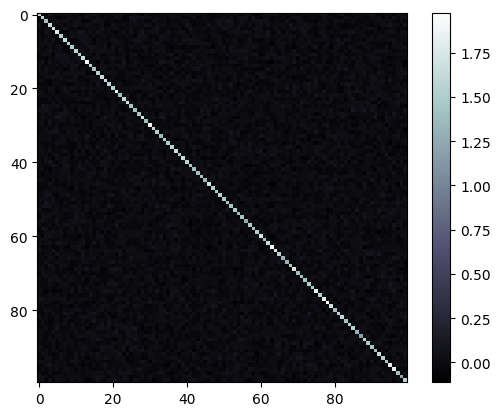

In [28]:
plt.imshow(noise_prec_shrink), plt.colorbar()
None

### estimates based on residuals
A different source for the noise covariance can be measures from an earlier step in the analysis, which lead to the dataset object. Most of the times these measures would be the residuals of a 1st level analysis to estimate the activations caused by the conditions or stimuli.

To use this source for the noise covariance simply put the measurements you wish to use into a $n_{res}\times k$ matrix, where $k$ is the number of measurement channels and run the following commands from the noise handling in rsatoolbox:

In [29]:
residuals = np.random.randn(1000, dataset.n_channel) # obviously do not use random residuals for this in applications
noise_pres_res = rsatoolbox.data.noise.prec_from_residuals(residuals)

`rsatoolbox.data.noise.prec_from_residuals` takes the same method argument as `prec_from_measurements` allowing for diagonal covariance and shrinkage estimates.

Also there is a `dof` argument, which allows you to provide the degrees of freedom left in the residuals to correct the estimate for components removed via regression. This only scales the matrix, which means that this can be ignored if the absolute scale of the RDM does not matter to you.

### Computing Mahalanobis distances
Mahalanobis distances is the simplest form of dissimilarities to take the covariance between measurement channels into account. This is reweighting channels with the estimate of the precision matrix.

In rsatoolbox this is implemented as the `'mahalanobis'` method parameter of `calc_rdm`. The noise precision is passed as the `noise` parameter. For comparison we here also compute the euclidean RDM on the original data:

In [30]:
rdm_euc = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='euclidean')
rdm_maha_diag = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='mahalanobis', noise=noise_prec_diag)
rdm_maha_shrink = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='mahalanobis', noise=noise_prec_shrink)

To compare the three estimated rdms, we can plot them with the following code. In this case the differences are fairly small, as we added independent and equally sized noise to the measurements. When the measurement channels are correlated and/or differently noisy this will result in larger differences..

In [31]:
np.concatenate([rdm_euc.get_matrices(), rdm_maha_diag.get_matrices(), rdm_maha_shrink.get_matrices()], axis=0).shape

(3, 92, 92)

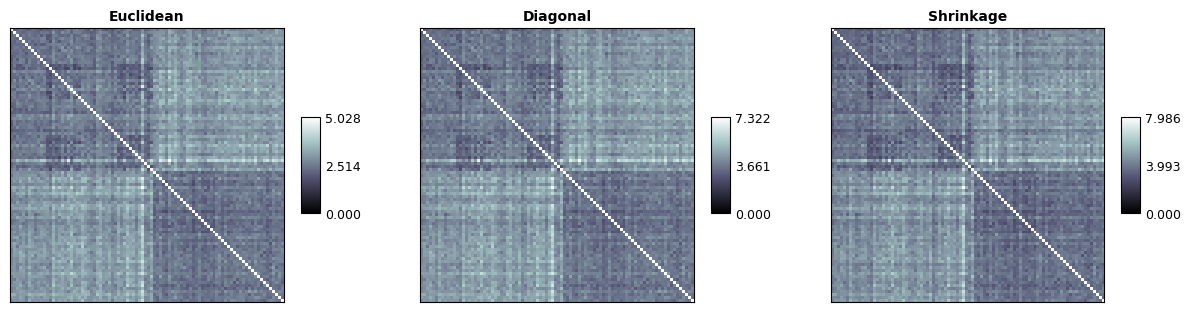

In [32]:
rsatoolbox.vis.show_rdm(
    rsatoolbox.rdm.RDMs(
        np.concatenate(
            [rdm_euc.get_matrices(), 
             rdm_maha_diag.get_matrices(),
             rdm_maha_shrink.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Euclidean', 'Diagonal', 'Shrinkage'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)
None

Taking the noise covariance into account can be combined with crossvalidated dissimilarities by computing cross-nobis dissimilarities. This is implemented as the `crossnobis` method of calculating RDMs in rsatoolbox:

In [33]:
rdm_cv_eye = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=None, cv_descriptor='sessions')
rdm_cv_diag = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=noise_prec_diag, cv_descriptor='sessions')
rdm_cv_shrink = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=noise_prec_shrink, cv_descriptor='sessions')

And we can of course plot these matrices again:

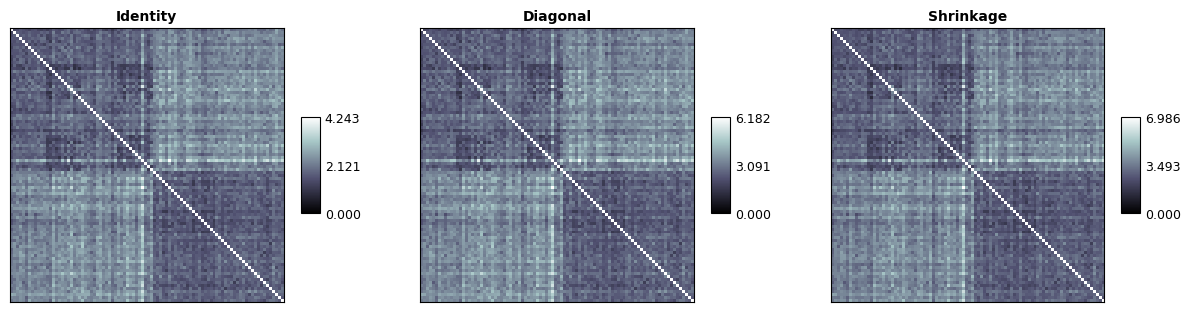

In [34]:
rsatoolbox.vis.show_rdm(
    rsatoolbox.rdm.RDMs(
        np.concatenate(
            [rdm_cv_eye.get_matrices(), 
             rdm_cv_diag.get_matrices(),
             rdm_cv_shrink.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Identity', 'Diagonal', 'Shrinkage'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)
None